In [41]:
from copy import deepcopy
from time import time

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize, root_scalar


from sklearn.cluster import DBSCAN, KMeans, MeanShift
from sklearn.neighbors import NearestNeighbors as nn
from sklearn.metrics import pairwise_distances
import sklearn

### DBSCAN

In [2]:
def reader(file_name, skip_lines=0, commos2points=False):
    '''
    read only 3 coords
    return np.array

    '''

    list_obj = list()
    with open(file_name, 'r') as fd_file:
        for line in fd_file:
            if skip_lines:
                skip_lines -= 1
                continue
            if commos2points:
                line = line.replace(',', '.')
            line = line.split()
            coords = np.zeros(shape=(3,))
            coords[0] = float(line[0])
            coords[1] = float(line[1])
            coords[2] = float(line[2])
            list_obj.append(coords)
    return np.array(list_obj)

def get_cone(array, ra, dec, offset=1.5):
    mask = ((array[:,0] > ra - offset) & (array[:, 0] < ra + offset) &
            (array[:,1] > dec - offset) & (array[:,1] < dec + offset))
    return array[mask]


def left_right_regions(points_ra_dec):
    array = points_ra_dec
    mask_right = (((array[:,0] < 60) | (array[:,0] > 306)) &
                  (array[:, 1] > -12) & (array[:, 1] < 37))
    mask_left = ((array[:,0] > 102) & (array[:,0] < 270) & 
                 (array[:,1] > -4) & (array[:,1] < 69))
    
    return array[mask_left], array[mask_right]

def do_scan(points_xyz, n_neighbors, eps, verbose=False):
    num_clusters_inter = 4
    
    dbscan = DBSCAN(eps=eps, min_samples=n_neighbors+1).fit(points_xyz)
    cen_dbscan = points_xyz[dbscan.labels_==0].mean(axis=0)

    clusters = list()
    cen_clusters = list()

    labels, count_labels = np.unique(dbscan.labels_, return_counts=True)
    most_freq_labels = labels[np.argsort(count_labels)[::-1][:num_clusters_inter]]

    for lab in most_freq_labels:
        if lab == -1:
            continue
        clusters.append(points_xyz[dbscan.labels_==lab])    
        cen_clusters.append(clusters[-1].mean(axis=0))
        if verbose:
            print('for label', lab, 'there are', clusters[-1].shape[0], 'galaxies')
    
    noize = points_xyz[dbscan.labels_==-1]
    if verbose:
        print('noize num : ', noize.shape)

    return clusters, cen_clusters, noize, dbscan.labels_


def to_ra_dec_redshift(points_xyz):
    if points_xyz.shape == (3,):
        points_xyz = points_xyz.reshape((1,3)) 
    redshift = np.linalg.norm(points_xyz, axis=1)
    ra = np.arctan(points_xyz[:,1]/points_xyz[:,0]) * 180.0 / np.pi
    dec = (90.0 - np.arccos(
        points_xyz[:,2]/np.linalg.norm(points_xyz, axis=1)) * 180.0 / np.pi)
    
    mask_2_3 = (points_xyz[:,0] < 0)
    mask_4 = ((points_xyz[:,0] > 0) & (points_xyz[:,1] < 0))
    
    ra[mask_2_3] = 180 + ra[mask_2_3]
    ra[mask_4] = 360 + ra[mask_4]
    
    points_sphere = np.zeros_like(points_xyz)
    points_sphere[:,0] = ra
    points_sphere[:,1] = dec
    points_sphere[:,2] = redshift
    

    return points_sphere


def to_xyz(polar_points):
    points = polar_points
    if points.shape == (3,):
        points = points.reshape((1,3))
    cos_dec = np.cos(points[:,1]*np.pi/180.0)
    sin_dec = np.sin(points[:,1]*np.pi/180.0)
    
    cos_ra = np.cos(points[:,0]*np.pi/180.0)
    sin_ra = np.sin(points[:,0]*np.pi/180.0)
    
    r = points[:,2]
    points_xyz = np.zeros_like(points)
    points_xyz[:,0] = r * cos_dec * cos_ra
    points_xyz[:,1] = r * cos_dec * sin_ra
    points_xyz[:,2] = r * sin_dec 
    return points_xyz

def func_distr(points, n_neighbors):
    #calculate dist to n_neighbor and indecies
    nbrs = nn(n_neighbors=n_neighbors+1, algorithm='ball_tree').fit(points)
    dist, ind = nbrs.kneighbors(points)
    dist_to_nneighbor = dist[:,n_neighbors]   
    return dist, ind

def shuffle_coords(arr_clusters):
    list_coords_shuffled = list()
    for coord in arr_clusters.T:
        coord_to_shuffle = deepcopy(coord)
        np.random.shuffle(coord_to_shuffle)
        list_coords_shuffled.append(coord_to_shuffle)
    
    arr_clusters_shuffled = np.array(list_coords_shuffled).T
    return arr_clusters_shuffled


def get_hist(arr_clusters, num_bins, right_edge):
    pair_dist_clusters = pairwise_distances(arr_clusters)
    not_zero_pair = np.triu(pair_dist_clusters)
    not_zero_pair = not_zero_pair[not_zero_pair!=0]
    arr_clusters.shape

    #to_del = np.unique(np.argwhere((pair_dist_clusters<2) & (pair_dist_clusters>0)).flatten())
    #arr_clusters = np.delete(arr_clusters, to_del, 0)

    n1 = np.histogram(not_zero_pair, num_bins, [0, right_edge])
    return n1


In [203]:
class distr_red_shift(stats.rv_continuous):
    max_prob_distr = 1.02
    max_val_distr = 0.3
    
    def __init__(self, min_val=0., max_val=max_val_distr):
        super().__init__()
        self.min_val = min_val
        self.max_val = max_val
    
    def _rvs(self):
        size = self._size[0]
        min_prob = self.cdf(self.min_val)
        max_prob = self.cdf(self.max_val)
        
        list_values = list()
        i = 0
        while i < size-1:
            prob = np.random.rand() * (max_prob - min_prob) + min_prob
            sol_eq = root_scalar(
                self.__make_equation_cdf, args=prob, bracket=[0, 0.3], method='brentq')
            if(sol_eq.converged):
                list_values.append(sol_eq.root)
                i+=1
        return np.array(list_values)        
    
    
    def _pdf(self, x):
        res = np.zeros_like(x)
        res[x <= 0.075] = 93.*x[x <= 0.075]
        res[(0.075 < x) & (x <= 0.09)] = 7
        res[(0.09 < x) & (x <= 0.14)]  = 5.8
        res[(0.14 < x) & (x <= 0.21)] = -50.*x[(0.14 < x) & (x <= 0.21)] + 12.
        res[(0.21 < x) & (x <= 0.3)] = 1.5
        return res
    
    def _cdf(self, x):
        res = np.zeros_like(x)
        res[x <= 0.075] = 46.5*x[x <= 0.075]**2
        res[(0.075 < x) & (x <= 0.09)] = 7.*x[(0.075 < x) & (x <= 0.09)] - 0.2625 
        res[(0.09 < x) & (x <= 0.14)] = 5.8*x[(0.09 < x) & (x <= 0.14)] - 0.1545 #0.522 + (0.2625 + 0.105)
        res[(0.14 < x) & (x <= 0.21)] = (-25.*x[(0.14 < x) & (x <= 0.21)]**2 
                                         + 12.*x[(0.14 < x) & (x <= 0.21)] - 0.5325)
        res[(0.21 < x) & (x <= 0.3)] = 1.5*x[(0.21 < x) & (x <= 0.3)] + 0.57
        res[x >= 0.3] = 1.02
        return res
    
    def __cdf_for_one(self, x):
        if x < 0:
            res = 0
        if x <= 0.075:
            res = 46.5*x**2
        if 0.075 < x <= 0.09:
            res = 7.*x - 0.2625 
        if 0.09 < x <= 0.14:
            res = 5.8 * x - 0.522 + (0.2625 + 0.105)
        if 0.14 < x <= 0.21:
            res = -25.*x**2 + 12.*x - 0.5325
        if 0.21 < x <= 0.3:
            res =  1.5*x + 0.57
        if x > 0.3:
            res = 1.02
        return res    
    
    def __make_equation_cdf(self, x, y):
        return self.__cdf_for_one(x) - y
    


In [3]:
def plot_distinguish(n1, n2):
    distinguish = n1[0] - n2[0]
    plt.errorbar(n2[1][1:], 
             np.zeros_like(n2[1][1:]), 
             yerr=[np.zeros_like(distinguish), distinguish], alpha=1)
    
def uniform_distr(points_xyz, in_polar):
    if in_polar:
        points = to_ra_dec_redshift(points_xyz)
    else:
        points = points_xyz
    new_coords = np.zeros_like(points)
    
    for i, coord in enumerate(points.T):
        max_ = np.max(coord)
        min_ = np.min(coord)
        if i==2 and in_polar:
            new_coords[:,i] = distr_red_shift(min_val=min_, max_val=max_).rvs(size=coord.shape[0]+1)
            continue   
        new_coord = np.random.rand(*coord.shape)*(max_ - min_) + min_
        new_coords[:,i] = new_coord
    if in_polar:
        return to_xyz(new_coords)
    return new_coords
        
def plot_results(array_clusters_xyz, 
                 num_bins, right_edge, 
                 mod_mix, 
                 save=False, name='all_diagrams'):
    '''
    mod_mix:
    1: mix red_shift
    2: mix all polar coords
    3: mix all xyz coords
    4: uniform polar coords
    5: uniform xyz coords
    '''
    
    mix_array_clusters_xyz = None
    mix_array_clusters_polar = None
    array_clusters_polar = to_ra_dec_redshift(array_clusters_xyz)
    
    
    if mod_mix==1:
        array_clusters_polar_mix = deepcopy(array_clusters_polar)
        array_clusters_polar_mix[:,2] = shuffle_coords(
            array_clusters_polar_mix[:,2].reshape(-1, 1)).reshape(-1,)

        mix_array_clusters_xyz = to_xyz(array_clusters_polar_mix)
    elif mod_mix==2:
        mix_array_clusters_xyz = to_xyz(shuffle_coords(array_clusters_polar))
    elif mod_mix==3:
        mix_array_clusters_xyz = shuffle_coords(array_clusters_xyz)
    elif mod_mix==4:
        mix_array_clusters_xyz = uniform_distr(array_clusters_xyz, in_polar=True)
    elif mod_mix==5:
        mix_array_clusters_xyz = uniform_distr(array_clusters_xyz, in_polar=False)
    
    mix_array_clusters_polar = to_ra_dec_redshift(mix_array_clusters_xyz)
    
    n1 = get_hist(array_clusters_xyz, num_bins, right_edge)           
    n2 = get_hist(mix_array_clusters_xyz, num_bins, right_edge)
    fig = plt.figure(figsize=(8, 20))
    plt.subplot(511)
    plt.scatter(n1[1][1:], n1[0], s=2)
    plt.scatter(n2[1][1:], n2[0], s=2, alpha=0.8)
    plt.xlim([0, right_edge])
    plt.xticks(np.linspace(0, right_edge, 11))
    num_bao = round(right_edge/0.035)
    plt.xticks(np.linspace(0, num_bao*0.035, num_bao+1))
    plt.grid(True)
    
    plt.subplot(512)
    plot_distinguish(n1, n2)
    plt.xlim([0, right_edge])
    plt.xticks(np.linspace(0, num_bao*0.035, num_bao+1))
    plt.grid(True)
    
    num_bins = 50
    plt.subplot(513)
    plt.title('ra')
    plt.hist(array_clusters_polar[:,0], num_bins)
    plt.hist(mix_array_clusters_polar[:,0], num_bins, alpha=0.8)
    plt.grid(True)
    
    plt.subplot(514)
    plt.title('dec')
    plt.hist(array_clusters_polar[:,1], num_bins)
    plt.hist(mix_array_clusters_polar[:,1], num_bins, alpha=0.8)
    plt.grid(True)
    
    plt.subplot(515)
    plt.title('redshift')
    plt.hist(array_clusters_polar[:,2], num_bins)
    plt.hist(mix_array_clusters_polar[:,2], num_bins, alpha=0.8)
    plt.grid(True)
    
    if save:
        name = name + '.png'
        fig.savefig(name)

In [196]:
list_c = list()
with open('data/Abell clusters (ra, dec).txt', 'r') as fd:
    for line in fd:
        line = line.split()
        ra =float(line[0])
        dec = float(line[1])
        list_c.append([ra, dec])
        
abell_clusters_ray = np.array(list_c)
left_abell, right_abell = left_right_regions(abell_clusters_ray)


In [197]:
all_gal = reader('data/raw/0_03_Space.txt')
all_gal = all_gal[all_gal[:,2]>10e-4]
left_area, right_area = left_right_regions(all_gal)

In [6]:
left_area.shape

(751945, 3)

In [198]:
threshold_cone_with_cluster = 120
abell_ray = left_abell
area = left_area

list_cones = list()
list_no_clusters = list()
no_cluster_here = 0
for ra_dec in abell_ray:
    ra, dec = ra_dec[0], ra_dec[1]
    cone_with_cluster = (get_cone(area, ra, dec))
    if cone_with_cluster.shape[0] < threshold_cone_with_cluster:
        no_cluster_here += 1
        list_no_clusters.append(ra_dec)
    else:
        list_cones.append(cone_with_cluster)


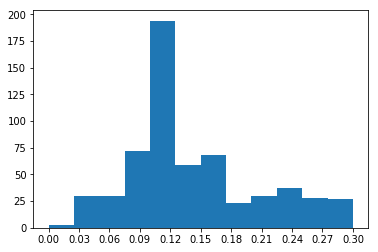

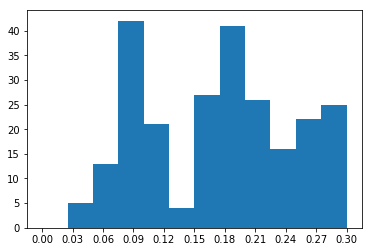

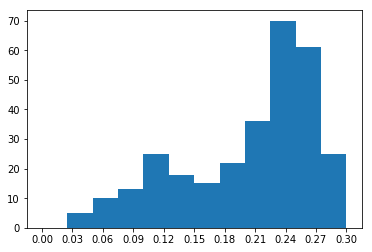

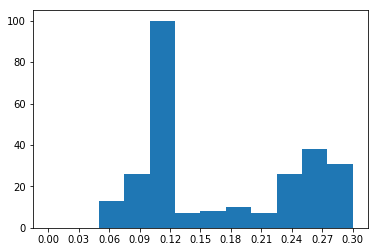

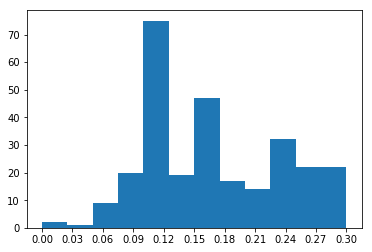

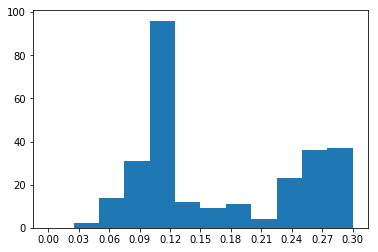

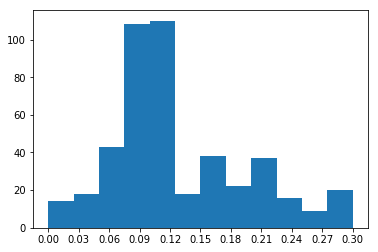

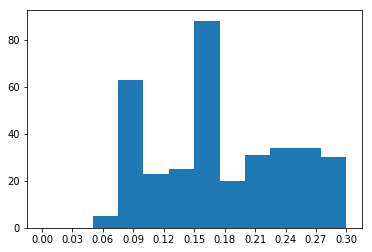

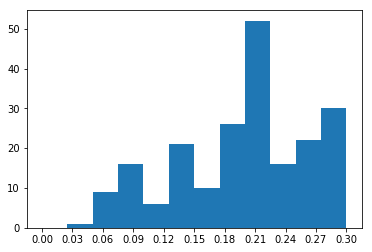

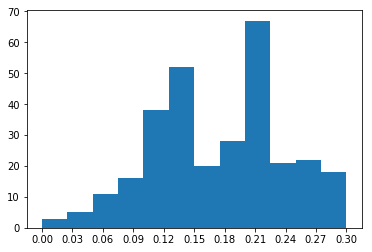

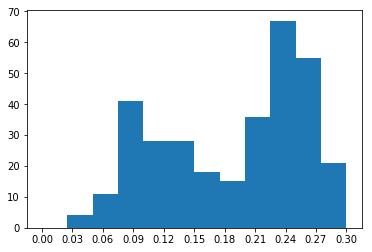

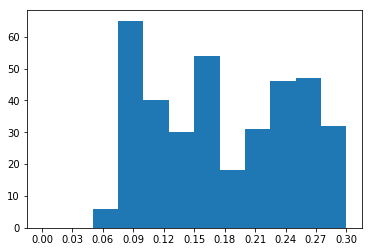

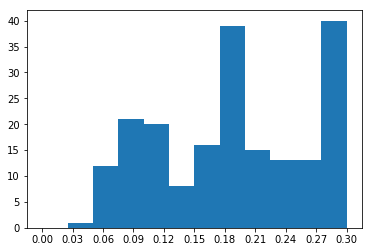

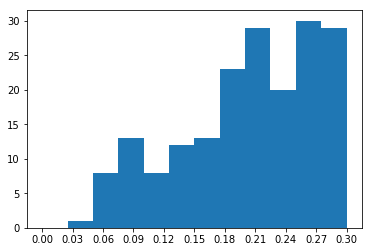

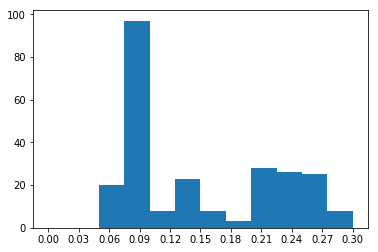

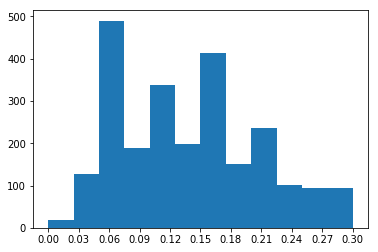

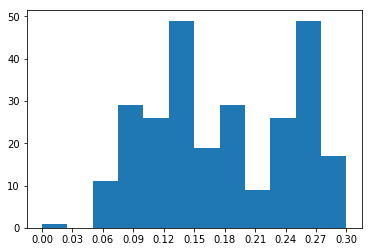

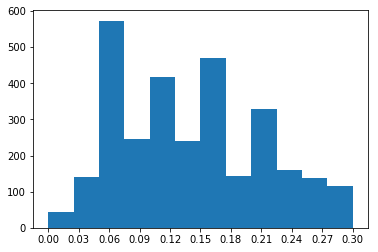

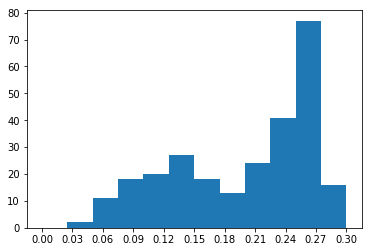

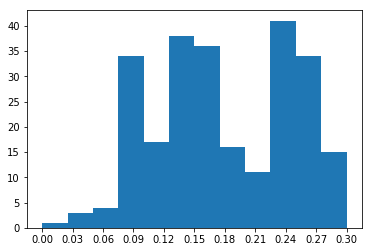

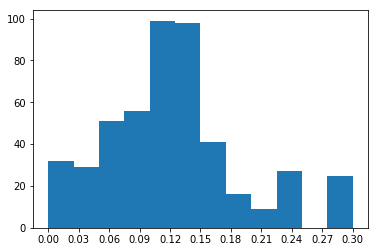

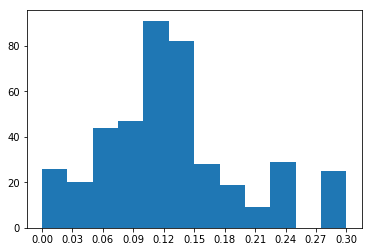

KeyboardInterrupt: 

In [222]:
for cone in list_cones:
    plt.hist(cone[:,2], 12, [0, 0.3])
    plt.xticks(np.linspace(0, 0.3, 11))
    plt.show()
    

In [ ]:
k_means = KMeans(n_clusters=1300, algorithm='elkan', verbose=2)
res_k_means = k_means.fit_predict(to_xyz(left_area))

In [ ]:
mean_shift = MeanShift(cluster_all=False)
res_mean_shift = mean_shift.fit_predict(to_xyz(left_area))

In [200]:
def analyze_seria(list_cones, verbose=False):
    '''
    seria of less chosen files
    
    '''
    coef_hugest_cluster = 0.4
    coef_2_clusters = 0.3
    coef_1st_to_2nd = 0.25
    many_galaxies = 500

    all_clusters = list()
    not_big = 0
    two_small = 0
    not_big_70 = 0
    bad_alg = 0
    two_clusters = 0
    bad_cluster = 0 
    
    all_clusters = list()
    
    for cone in list_cones:
        points_xyz = to_xyz(cone)
        num_galaxies = points_xyz.shape[0]
        pair_dist = pairwise_distances(points_xyz)
        not_zero_pair = np.triu(pair_dist)
        med = np.median(not_zero_pair[not_zero_pair!=0])
        
        if num_galaxies > many_galaxies:
            clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=5, eps=med*0.2)
        else:
            clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=3, eps=med*0.3)
        
        num_bigest = clusters[0].shape[0]
        if len(clusters) == 1:
            num_second = 0
        else:
            num_second = clusters[1].shape[0]
        
        if num_galaxies > many_galaxies:
            if (num_bigest-num_second)/num_bigest < coef_1st_to_2nd:
                if num_bigest > coef_2_clusters:
                    all_clusters.append(cen_clusters[0])
                    all_clusters.append(cen_clusters[1])
                    two_clusters += 1
                else:
                     two_small += 1
            elif num_bigest/num_galaxies > coef_hugest_cluster:
                all_clusters.append(cen_clusters[0])
        
            else:
                not_big += 1
    
        elif num_bigest/num_galaxies > coef_hugest_cluster:
            all_clusters.append(cen_clusters[0])  
        else:
            not_big_70 += 1
    
    if verbose:
        print(not_big, two_small, two_clusters, not_big_70)
    arr_clusters = np.array(all_clusters)
    return arr_clusters 

In [201]:
tmp1 = analyze_seria(list_cones, True)

0 0 7 0


In [204]:
tmp1.shape

(1296, 3)

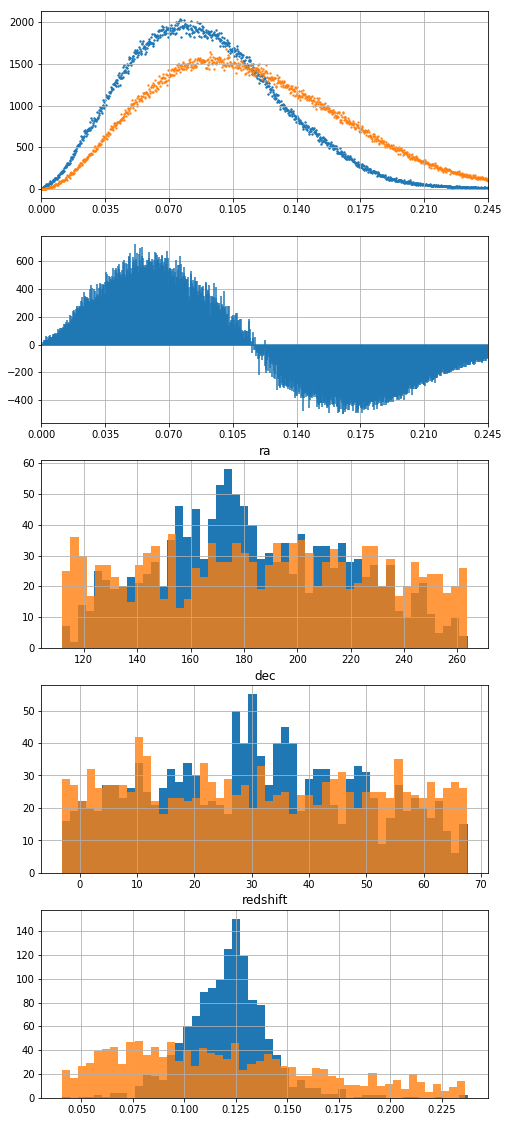

In [207]:
plot_results(tmp1, 1000, 0.245, mod_mix=4)

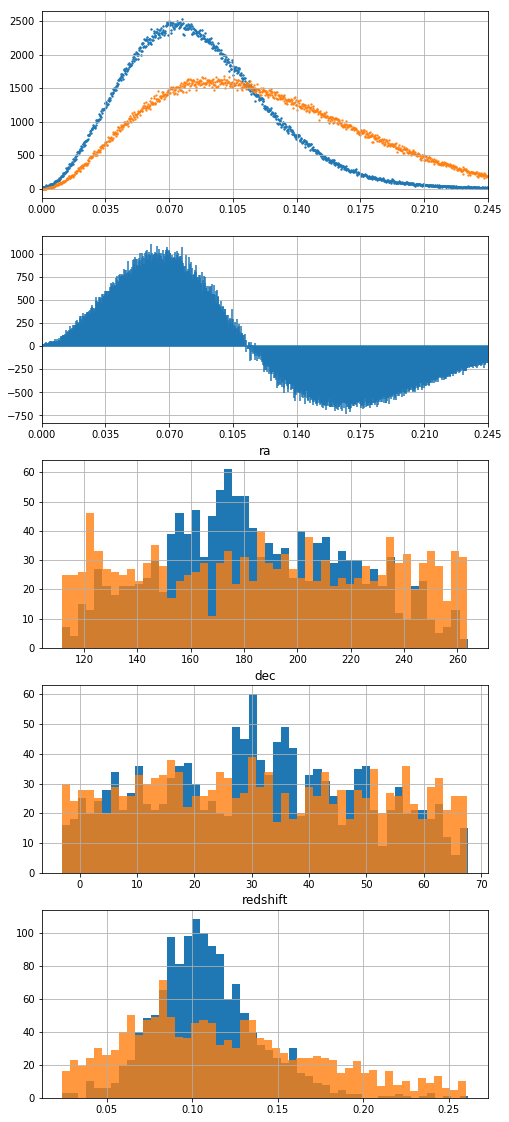

In [973]:
plot_results(tmp, 1000, 0.245, mod_mix=4)

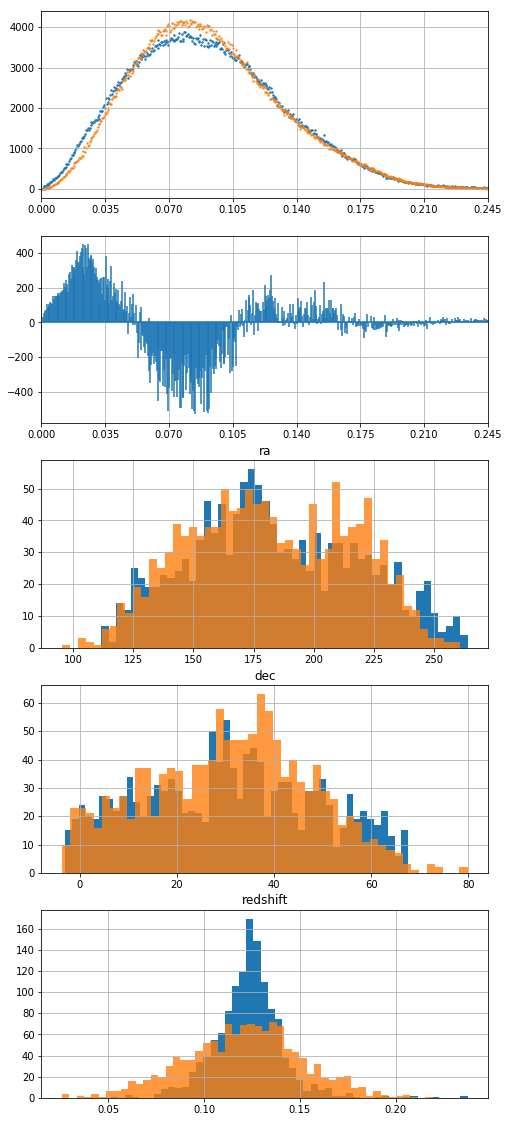

In [964]:
plot_results(arr_cl_dummy, 500, 0.245, mod_mix=3)
#plot_results(tmp, 2000, 0.25)

In [313]:
bot_edge = 0
top_edge = 12
scale_coef = 0.0087
eps=scale_coef*10e-4
cub_struct = np.zeros(((top_edge-bot_edge)**3 + 11*12*12, 3))
noize = (np.random.random_sample(size=cub_struct.shape)-0.5)/3 + 1

idx = 0
for i in range(-11, top_edge):
    for j in range(bot_edge, top_edge):
        for k in range(bot_edge, top_edge):
            cub_struct[idx, 0] = i + eps
            cub_struct[idx, 1] = j + eps
            cub_struct[idx, 2] = k + eps
            idx+=1
            
cub_struct = cub_struct * scale_coef * noize

array=to_ra_dec_redshift(cub_struct)
ra = 0.
mask = ((array[:,0] > ra - 75.) & (array[:, 0] < ra + 75.) &
            (array[:,1] > 0.1) & (array[:,1] < 65.))
cub_struct_cutted = to_xyz(array[mask])

In [308]:
unif_cutted = uniform_distr(cub_struct, False)
array=to_ra_dec_redshift(unif_cutted)
ra = 0.
mask = ((array[:,0] > ra - 75.) & (array[:, 0] < ra + 75.) &
            (array[:,1] > 0.) & (array[:,1] < 65.))
unif_cutted = to_xyz(array[mask])

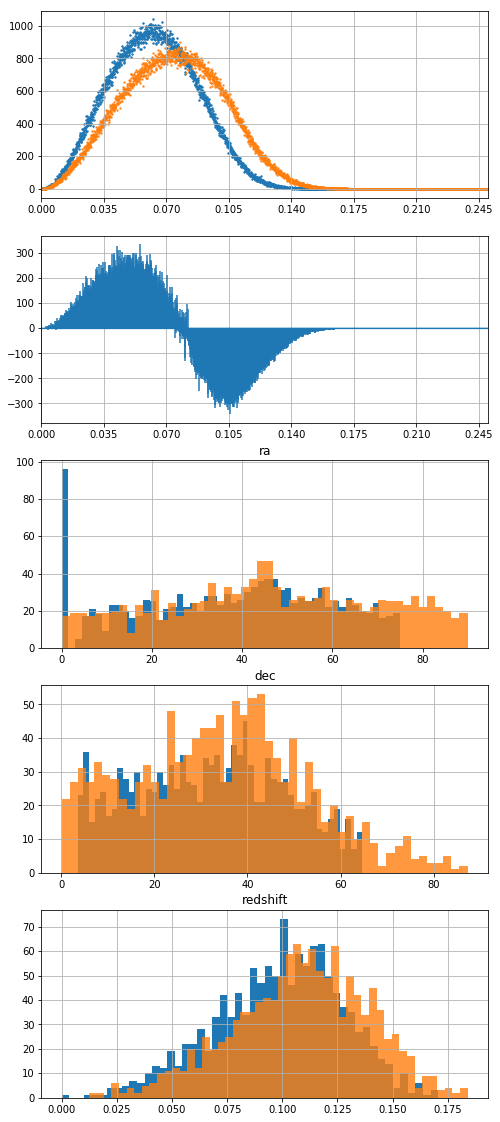

In [314]:
plot_results(cub_struct_cutted, 3000, 0.25, mod_mix=5)

In [293]:
min(cub_struct[:, 2]) / 0.035

3.0629190243193575e-05

In [286]:
uniform_distr(cub_struct, in_polar=True)

array([[ 0.11357792,  0.06215384,  0.24247759],
       [ 0.01870737,  0.01229132,  0.05923897],
       [ 0.0086103 ,  0.02576406,  0.06570405],
       ..., 
       [ 0.01953556,  0.01156802,  0.07764621],
       [-0.01038169,  0.00305078,  0.1064924 ],
       [ 0.01049375,  0.00685654,  0.0360866 ]])

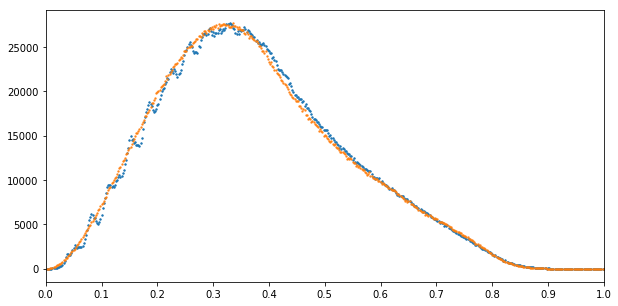

In [304]:
num_bins = 500
right_edge = 1
n1 = get_hist(cub_struct, num_bins, right_edge)           
n2 = get_hist(uniform_distr(cub_struct, in_polar=False), num_bins, right_edge)



fig = plt.figure(figsize=(10, 5))
plt.scatter(n1[1][1:], n1[0], s=2)
plt.scatter(n2[1][1:], n2[0], s=2, alpha=0.8)
plt.xlim([0, right_edge])
plt.xticks(np.linspace(0, right_edge, 11))
plt.show()

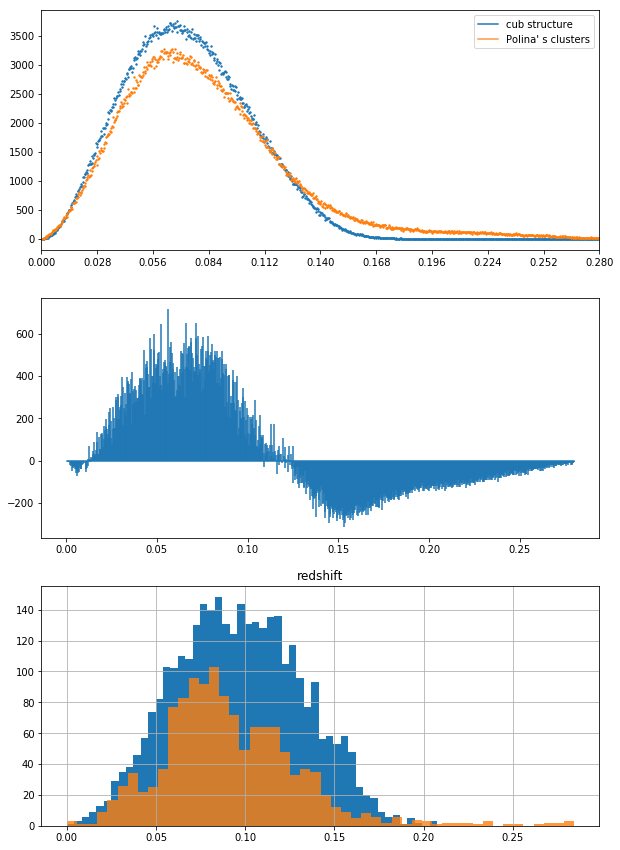

In [223]:
num_bins = 800
right_edge = 0.28
n1 = get_hist(cub_struct_cutted, num_bins, right_edge)  
n3 = get_hist(to_xyz(polina_clusters_left), num_bins, right_edge)  

fig = plt.figure(figsize=(10, 15))
plt.subplot(311)
plt.scatter(n1[1][1:], n1[0], s=2)
plt.scatter(n3[1][1:], n3[0], s=2)
plt.xlim([0, right_edge])
plt.xticks(np.linspace(0, right_edge, 11))

cub = mlines.Line2D([], [], color='C0', label='cub structure')
pol = mlines.Line2D([], [], color='C1', alpha=0.8, label="Polina' s clusters")
plt.legend(handles=[cub, pol])

#plt.show()
plt.subplot(312)
plot_distinguish(n1, n3)


plt.subplot(313)
plt.title('redshift')
plt.hist(to_ra_dec_redshift(cub_struct)[:,2], 50)
plt.hist(polina_clusters_left[:,2], 50, alpha=0.8)
plt.grid(True)
plt.show()

## Работа с кластерами Полины

In [8]:
polina_clusters = reader('data/Clusters Polina.txt', commos2points=True)
mask_na = np.any(np.isnan(polina_clusters), axis=1)
polina_clusters = polina_clusters[~mask_na]
polina_clusters_left, _ = left_right_regions(polina_clusters)

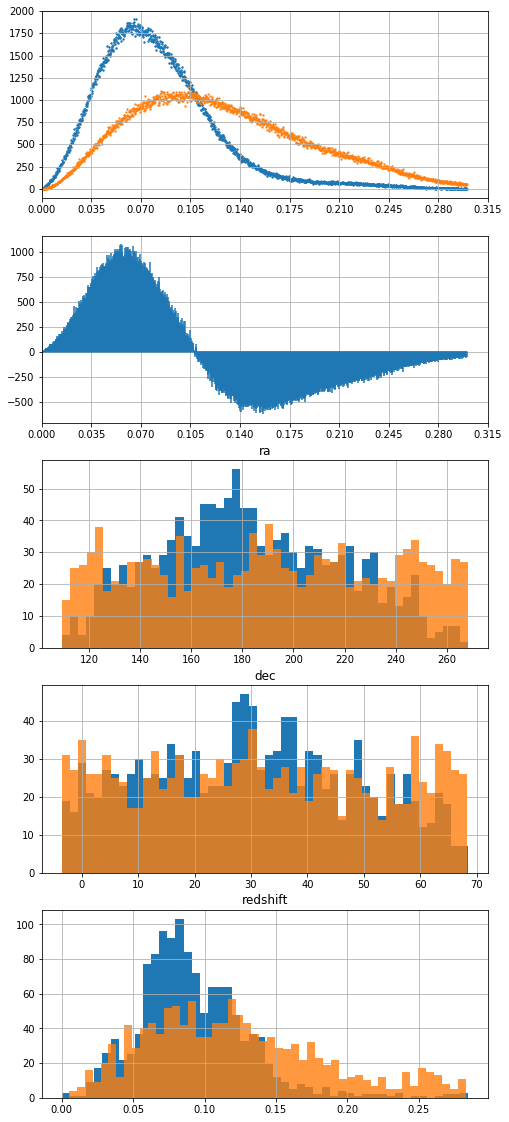

In [280]:
plot_results(to_xyz(polina_clusters_left), 1500, 0.3, mod_mix=4, save=False, name='uniform xyz')

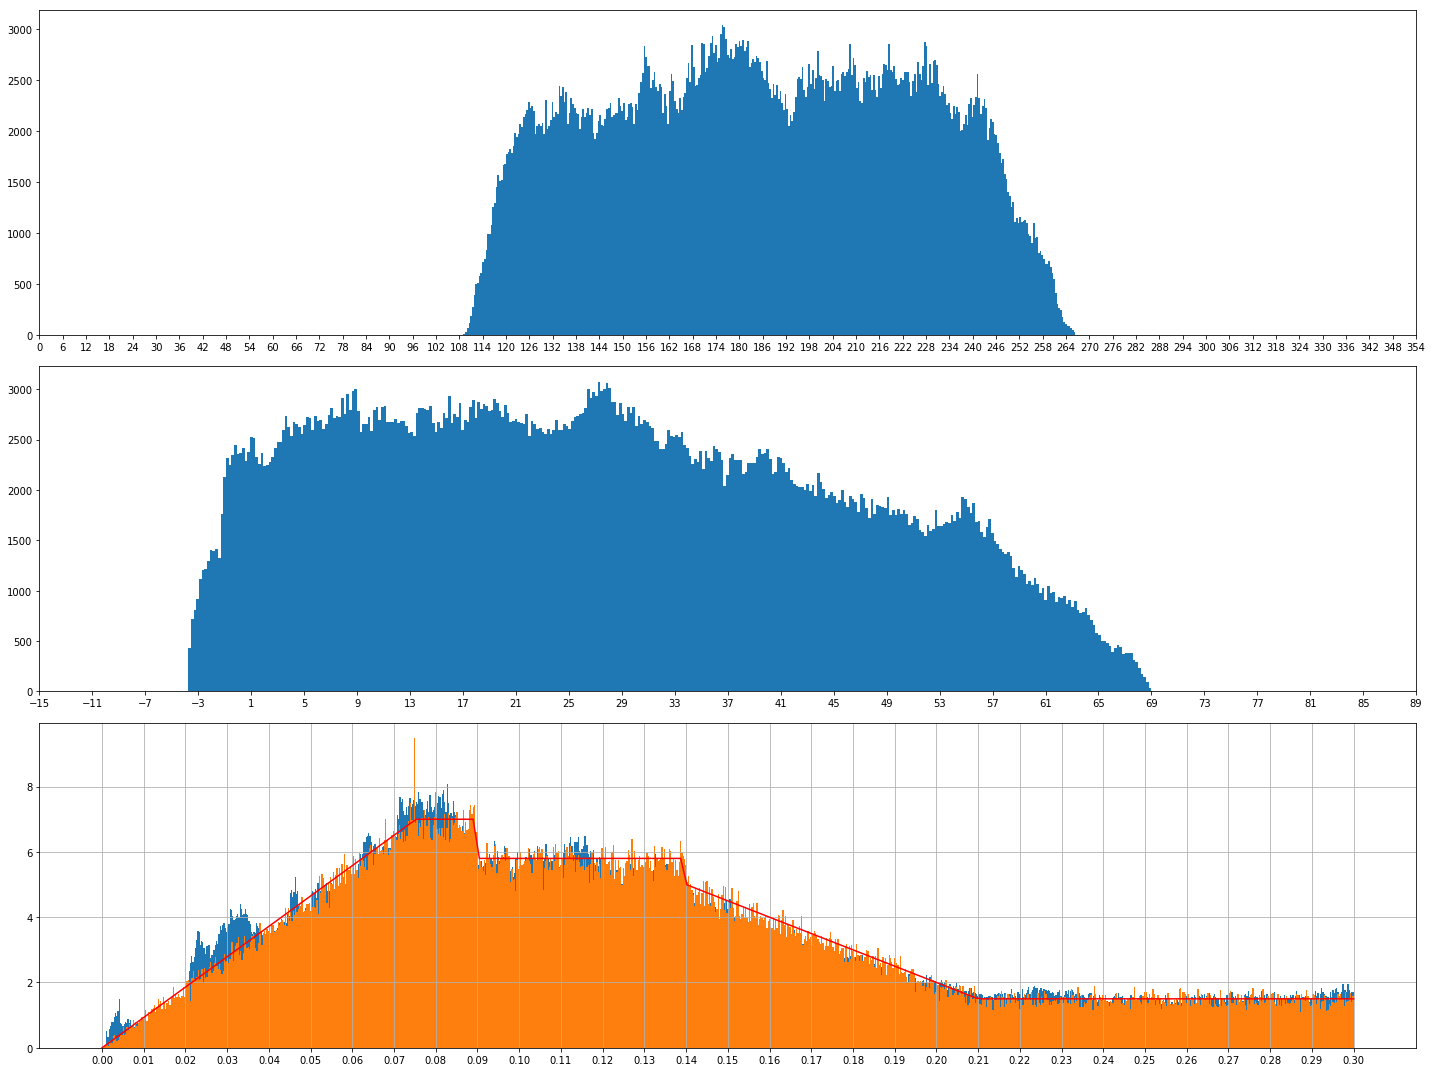

In [884]:
fig = plt.figure(figsize=(20, 15))

data = left_area
ax = plt.subplot(3, 1, 1)
plt.hist(data[:,0], bins=360)
plt.xticks(range(0, 360, 6))

ax = plt.subplot(3, 1, 2)
plt.hist(data[:,1], bins=360)
plt.xticks(range(-15, 90, 4))

ax = plt.subplot(3, 1, 3)
plt.hist(data[:,2], bins=1000, density=True)


z_distr = distr_red_shift()
x = np.linspace(0, 0.3, 200)
pdf_fitted = z_distr.pdf(x)
plt.plot(x, pdf_fitted, color='r')
plt.hist(z_distr.rvs(size=200000), bins=1000, density=True, alpha=0.8)
plt.xticks(np.linspace(0, 0.3, 31))
plt.grid(True)
    
plt.tight_layout()

In [11]:
def do_scan_reg(points_xyz, eps, n_neighbors,
                c_very_small=20, c_small=50, c_huge=300):
    dbscan_model = DBSCAN(eps=eps, min_samples=n_neighbors+1, metric='euclidean', algorithm='ball_tree')
    res = dbscan_model.fit_predict(points_xyz)
    lab, counts = np.unique(res, return_counts=True)
    
    noize = counts[0]
    counts = counts[1:]
    very_small = counts[counts<c_very_small].shape[0]
    small = counts[counts<c_small].shape[0] - very_small
    good = counts[(counts<c_huge) & (counts>c_small)].shape[0]
    huge = counts[counts>c_huge].shape[0]
    
    print('noize/all = {0:.3f}'.format(noize/points_xyz.shape[0]))
    print('under {0}: {1}'.format(c_very_small, very_small))
    print('under {0}: {1}'.format(c_small, small))
    print('more {0}: {1}'.format(c_huge, huge))      
    print('bigest cluster: {0}'.format(max(counts)))
    print('good clusters: {0}'.format(good))
    return res, lab, counts
    

(455, 3)
max = 1332.073
mediana = 270.73776954646416
for label 0 there are 276 galaxies
for label 2 there are 60 galaxies
for label 4 there are 35 galaxies
noize num :  (24, 3)


<IPython.core.display.Javascript object>


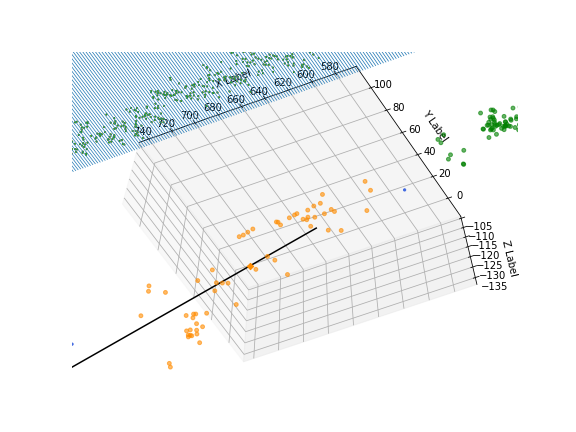

0
1
2


In [574]:
#dir_path = 'data/Abell less 0.3 chosen/'
#name_file = 'Abell_9 less 0.3 chosen.txt'

dir_path = 'data/Abell less 0.3/'
name_file = 'Abell_g_less_0.3 8.txt'

full_path = dir_path + name_file
points_xyz, ray = get_one(full_path)
print(points_xyz.shape)


pair_dist = pairwise_distances(points_xyz)
not_zero_pair = np.triu(pair_dist)
print("max = {0:.3f}".format(np.max(not_zero_pair[not_zero_pair!=0])))

med = np.median(not_zero_pair[not_zero_pair!=0])
print("mediana = {0}".format(med))

clusters, cen_clusters, noize, labels_ = do_scan(points_xyz, n_neighbors=5, eps=med/8, verbose=True)
%matplotlib notebook
fig = plt.figure(figsize=(8,6))
colours = ['royalblue', 'green', 'darkorange', 'purple']
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(0, 0, 0, c='black', s=20)
ax.plot([ray[0]/2, ray[0]], [ray[1]/2, ray[1]], [ray[2]/2, ray[2]], c='black')
for i, cluster in enumerate(clusters):
    print(i)
    if i >= 3:
        break
    ax.scatter(*(cluster.T), c=colours[i+1], s=15, alpha=0.6)
    ax.scatter((*cen_clusters[i]), c=colours[i+1], s=20, marker='D') 
ax.scatter(*(noize.T), c=colours[0], s=5, alpha=1)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
#ax.set_zticks([])
#plt.xticks([], [])
#plt.yticks([], [])

plt.axis('equal')
#plt.gca().set_aspect('equal', adjustable='box')
#ax.set_zlim(10, 500)
plt.grid('True')
plt.show()
